##ThinkDSP

This notebook contains code examples from Chapter 9: Differentiation and Integration

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import thinkstats2

import numpy as np
import pandas as pd
import scipy.signal

import warnings
warnings.filterwarnings('ignore')

PI2 = 2 * np.pi

np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

As the first example, I'll look at daily closing stock prices for Facebook, from its IPO on 17 May 2012 to 8 December 2015 (note: the dataset includes only trading days )

In [2]:
names = ['date', 'open', 'high', 'low', 'close', 'volume']
df = pd.read_csv('fb.csv', header=0, names=names, parse_dates=[0])
ys = df.close.values[::-1]
len(ys)

896

Here's what the time series looks like (ignoring the actual gaps between trading days).

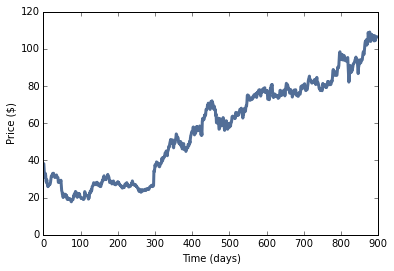

In [3]:
close = thinkdsp.Wave(ys, framerate=1)
close.plot()
thinkplot.config(xlabel='Time (days)', ylabel='Price ($)')

And here's the spectrum on a log-log scale.

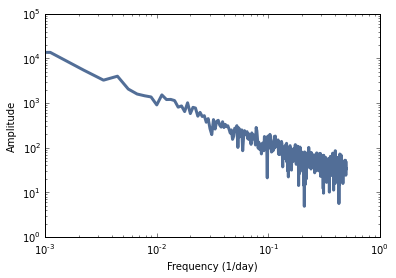

In [4]:
close_spectrum = close.make_spectrum()
close_spectrum.plot()
thinkplot.config(xlabel='Frequency (1/day)', ylabel='Amplitude',
                 xscale='log', yscale='log')

The slope of the power spectrum is -1.86, which is similar to red noise (which should have a slope of -2).

In [5]:
close_spectrum.estimate_slope().slope

-1.8579804334942203

We can use `np.diff` to compute the difference between successive elements, which is the daily change.

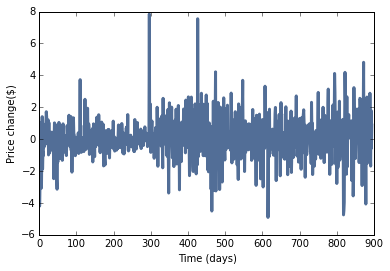

In [6]:
change = thinkdsp.Wave(np.diff(ys), framerate=1)
change.plot()
thinkplot.config(xlabel='Time (days)', ylabel='Price change($)')

And here's the spectrum of the daily changes:

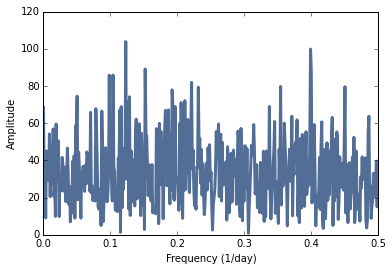

In [7]:
change_spectrum = change.make_spectrum()
change_spectrum.plot()
thinkplot.config(xlabel='Frequency (1/day)', ylabel='Amplitude')

Recall that the spectrum of white noise looks like white noise.

Here's the spectrum on a log-log scale.

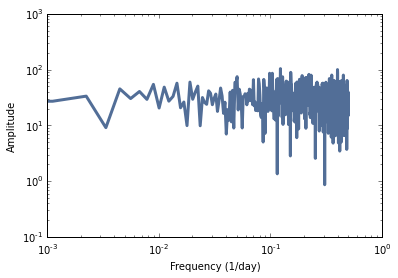

In [8]:
change_spectrum.plot()
thinkplot.config(xlabel='Frequency (1/day)', ylabel='Amplitude',
                 xscale='log', yscale='log')

The estimated slope is close to zero, which is consistent with white noise.

In [9]:
change_spectrum.estimate_slope().slope

-0.057272132941353193

We can think the diff operation as convolution with a difference window, [1, -1].

And convolution with this window corresponds to multiplication by a filter.

The following function computes the filter that corresponds to the window.

In [10]:
def make_filter(window, wave):
    """Computes the filter that corresponds to a window.
    
    window: NumPy array
    wave: wave used to choose the length and framerate
    
    returns: new Spectrum
    """
    padded = thinkdsp.zero_pad(window, len(wave))
    window_wave = thinkdsp.Wave(padded, framerate=wave.framerate)
    window_spectrum = window_wave.make_spectrum()
    return window_spectrum

And here's what the filter looks like for the difference window:

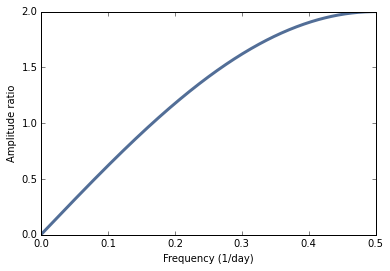

In [11]:
diff_window = np.array([1.0, -1.0])
diff_filter = make_filter(diff_window, close)
diff_filter.plot()
thinkplot.config(xlabel='Frequency (1/day)', ylabel='Amplitude ratio')

And the angles:

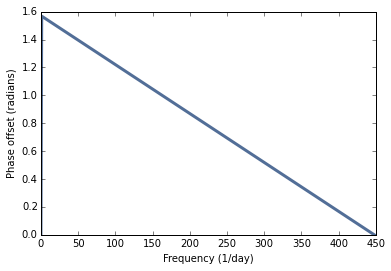

In [12]:
thinkplot.plot(diff_filter.angles)
thinkplot.config(xlabel='Frequency (1/day)', ylabel='Phase offset (radians)')

So we could also compute the daily changes by multiplying the spectrum of closing prices by the diff filter:

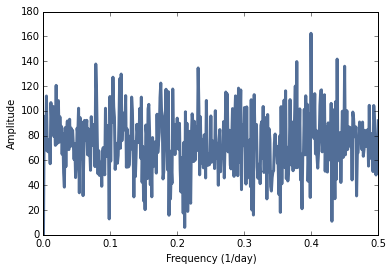

In [13]:
change_spectrum2 = close_spectrum * diff_filter
change_spectrum2.plot()
thinkplot.config(xlabel='Frequency (1/day)', ylabel='Amplitude')

And then converting the spectrum to a wave.

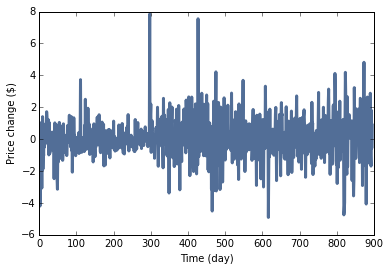

In [14]:
change2 = change_spectrum2.make_wave()

# we have to trim the first element to avoid wrap-around
change2.ys = change2.ys[1:]
change2.ts = change2.ts[1:]

change2.plot()
thinkplot.config(xlabel='Time (day)', ylabel='Price change ($)')

Then we can confirm that we get the same result both ways (within floating point error).

In [15]:
max(abs(change.ys - change2.ys))

3.1308289294429414e-13

###Differentiation

This diff operation is an approximation of differentiation, and we can compute the filter for differentiation analytically: each complex component is multiplied by $2 \pi i f$.

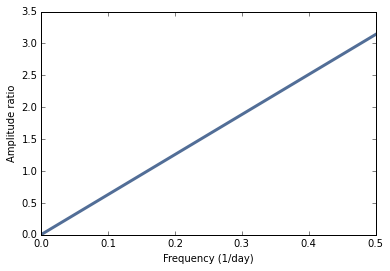

In [16]:
#start with a filter that has the right size, then replace hs
deriv_filter = close.make_spectrum()
deriv_filter.hs = PI2 * 1j * deriv_filter.fs
deriv_filter.plot()
thinkplot.config(xlabel='Frequency (1/day)', ylabel='Amplitude ratio')

Now we can apply the derivative filter to the spectrum of closing prices:

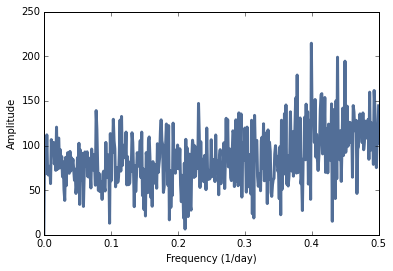

In [17]:
deriv_spectrum = close.make_spectrum()
deriv_spectrum.differentiate()

deriv_spectrum.plot()
thinkplot.config(xlabel='Frequency (1/day)', ylabel='Amplitude')

The results are similar to what we got from `np.diff`, with some differences due to (1) the difference window is only a coarse approximation of the derivative, especially at higher frequencies, and (2) the spectral derivative is based on the assumption that the signal is periodic, so the behavior at the beginning and end is different.

In [18]:
deriv = deriv_spectrum.make_wave()
len(deriv), len(change)

(896, 895)

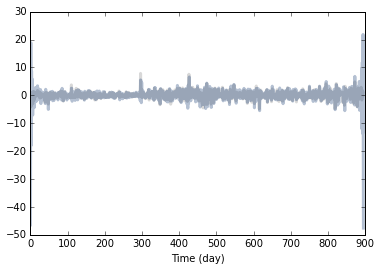

In [19]:
GRAY = '0.7'
deriv = deriv_spectrum.make_wave()
change.plot(color=GRAY, alpha=0.5)
deriv.plot(alpha=0.3)
thinkplot.config(xlabel='Time (day)')

We can see the differences more clearly by zooming in on a slice:

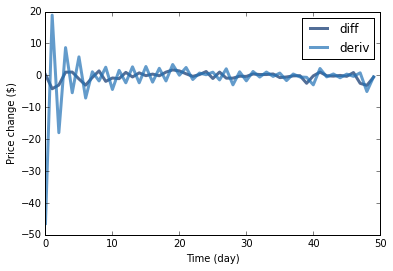

In [20]:
low, high = 0, 50
thinkplot.preplot(2)
thinkplot.plot(change.ys[low:high], label='diff')
thinkplot.plot(deriv.ys[low:high], label='deriv')
thinkplot.config(xlabel='Time (day)', ylabel='Price change ($)')

The diffs and the spectral derivative are similar in many places, but sometimes substantially different.

Here's the difference between the derivative filter and the difference filter:

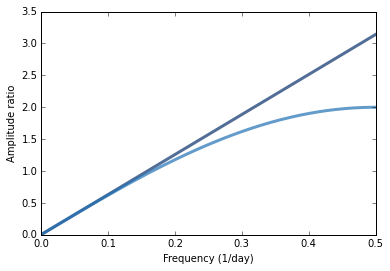

In [21]:
deriv_filter.plot()
diff_filter.plot()
thinkplot.config(xlabel='Frequency (1/day)', ylabel='Amplitude ratio')

The difference filter does not amplify the highest frequencies as much, which is why the diffs are smoother than the derivative.

## Integration

Now let's think about integration.  We can compute the filter for integration analytically: each frequency component gets divided by $2 \pi i f$.

I plot the result on a log-y scale so we can see it more clearly.

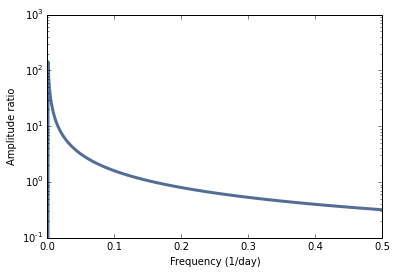

In [22]:
#start with a copy of the deriv filter and replace the hs
integ_filter = deriv_filter.copy()
integ_filter.hs = 1 / (PI2 * 1j * integ_filter.fs)

# set the component at freq=0 to 0
integ_filter.hs[0] = 0

integ_filter.plot()
thinkplot.config(xlabel='Frequency (1/day)', ylabel='Amplitude ratio', 
                 yscale='log')

We can confirm that the integration filter is correct by applying it to the spectrum of the derivative we just computed:

(nan+nan*j)


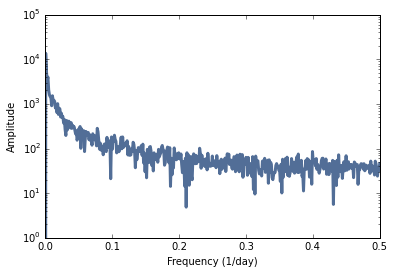

In [23]:
integ_spectrum = deriv_spectrum.copy()
integ_spectrum.integrate()
print(integ_spectrum.hs[0])
integ_spectrum.hs[0] = 0
integ_spectrum.plot()
thinkplot.config(xlabel='Frequency (1/day)', ylabel='Amplitude')
thinkplot.config(yscale='log')

And then converting back to a wave.  The result is identical to the daily closing prices we started with, but shifted so the mean is 0.  

The reason the mean is 0 is that the derivative clobbers the first element of the spectrum, which is the bias.  Once the bias information is lost, integration can't restore it.  So the result has an unspecified constant of integration.

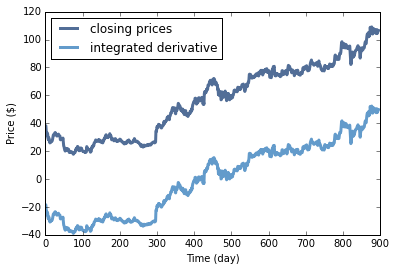

In [24]:
thinkplot.preplot(2)
integ_wave = integ_spectrum.make_wave()
close.plot(label='closing prices')
integ_wave.plot(label='integrated derivative')
thinkplot.config(xlabel='Time (day)', ylabel='Price ($)', 
                 legend=True, loc='upper left')

And we can confirm that the difference is very small.

In [25]:
shift = np.mean(close.ys) - np.mean(integ_wave.ys)
max(abs(integ_wave.ys-close.ys+shift))

2.4158453015843406e-13

###Cumulative sum

In the same way that the diff operator approximates differentiation, the cumulative sum approximates integration.

I'll demonstrate with a Sawtooth signal.

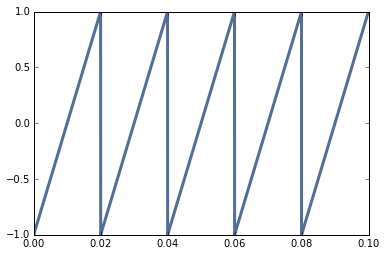

In [26]:
in_wave = thinkdsp.SawtoothSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()

Here's the spectrum before the cumulative sum:

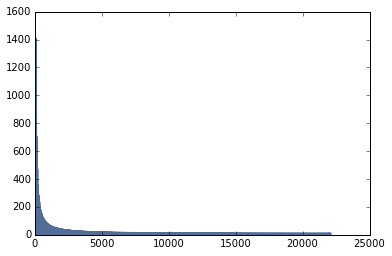

In [27]:
in_spectrum = in_wave.make_spectrum()
in_spectrum.plot()
thinkplot.config()

The output wave is the cumulative sum of the input

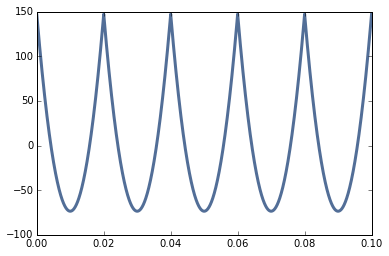

In [28]:
out_wave = in_wave.cumsum()
out_wave.unbias()
out_wave.plot()

And here's its spectrum

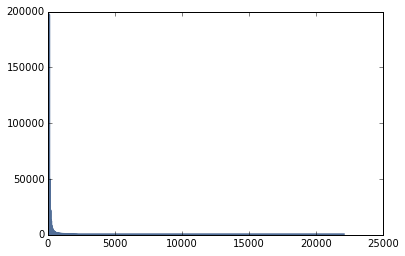

In [29]:
out_spectrum = out_wave.make_spectrum()
out_spectrum.plot()

Now we compute the ratio of the output to the input:

In [30]:
sum(in_spectrum.amps < 1), len(in_spectrum)

(1765, 2206)

In between the harmonics, the input componenents are small, so I set those ratios to NaN.

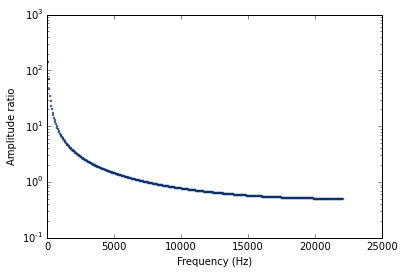

In [31]:
ratio_spectrum = out_spectrum.ratio(in_spectrum, thresh=1)
ratio_spectrum.plot(style='.', markersize=4)

thinkplot.config(xlabel='Frequency (Hz)',
                 ylabel='Amplitude ratio',
                 yscale='log')

To get the cumsum filter, I compute the diff filter again and invert it.

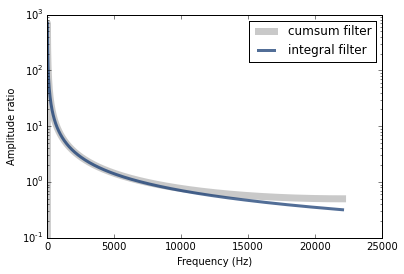

In [32]:
diff_window = np.array([1.0, -1.0])
padded = thinkdsp.zero_pad(diff_window, len(in_wave))
diff_wave = thinkdsp.Wave(padded, framerate=in_wave.framerate)
diff_filter = diff_wave.make_spectrum()

cumsum_filter = diff_filter.copy()
cumsum_filter.hs = 1 / cumsum_filter.hs
cumsum_filter.hs[0] = 0
cumsum_filter.plot(label='cumsum filter', color=GRAY, linewidth=7)

integ_filter = cumsum_filter.copy()
integ_filter.hs = integ_filter.framerate / (PI2 * 1j * integ_filter.fs)
integ_filter.plot(label='integral filter')

thinkplot.config(xlabel='Frequency (Hz)',
                 ylabel='Amplitude ratio',
                 yscale='log', 
                 legend=True, loc='upper right')

Finally, we can compare the computed ratios to the filter.  They match, confirming that the cumsum filter is the inverse of the diff filter.

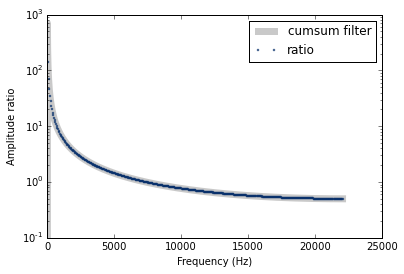

In [33]:
cumsum_filter.plot(label='cumsum filter', color=GRAY, linewidth=7)
ratio_spectrum.plot(label='ratio', style='.', markersize=4)
thinkplot.config(xlabel='Frequency (Hz)',
                 ylabel='Amplitude ratio',
                 yscale='log', legend=True)

Now we can compute the output wave using the convolution theorem, and compare the results:

In [34]:
len(in_spectrum), len(cumsum_filter)

(2206, 2206)

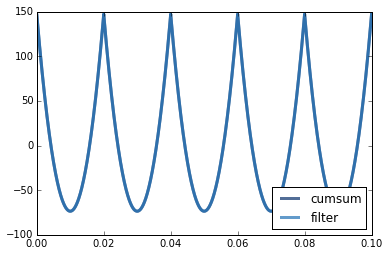

In [35]:
thinkplot.preplot(2)

out_wave.plot(label='cumsum')

out_wave2 = (in_spectrum * cumsum_filter).make_wave()
out_wave2.plot(label='filter')

thinkplot.config(legend=True, loc='lower right')

They are the same, within floating point error.

In [36]:
max(abs(out_wave.ys - out_wave2.ys))

1.2647660696529783e-12